In [13]:
import os 
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
import plotly.graph_objects as go
from src.utils.post_process import merge_bursts
from src.burst_detection.python.exhaustive_search import compute_all_bursts

import utils_notebook as utils
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm

In [14]:
threshold = 2.75
time_series_path = "../data/SST/mediterranean_average_processed.npy"
dates_series_path = "../data/SST/mediterranean_average_processed_dates.npy"
start_year = 1960
end_year = 2021
minimum_length = 1
maximum_length = 365
absolute = True
export = False
filename_html="example_unique_series.html"

if export:
    import plotly.io as pio
    pio.renderers.default='notebook'

In [15]:
print("\033[1m"+"Parameters: "+ "\033[0m")
print(f" - threshold = \033[1m{threshold}\033[0m : z-score theshold")
print(f" - time_series_path = \033[1m\"{time_series_path}\"\033[0m: path to the time series of values")
print(f" - dates_series_path = \033[1m\"{dates_series_path}\"\033[0m: path to the time series of dates")
print(f" - start_year = \033[1m{start_year}\033[0m: first year to study")
print(f" - end_year = \033[1m{end_year}\033[0m: last year to study")
print(f" - minimum_length = \033[1m{minimum_length}\033[0m: minimal interval length")
print(f" - maximum_length = \033[1m{maximum_length}\033[0m: maximal interval length")
print(f" - absolute = \033[1m{absolute}\033[0m: whether to compute bursts in absolute value or not")
print(f" - export = \033[1m{export}\033[0m: html export")
print(f" - filename_html = \033[1m\"{filename_html}\"\033[0m: html export file")

Parameters: 
 - threshold = 2.75 : z-score theshold
 - time_series_path = "../data/SST/mediterranean_average_processed.npy": path to the time series of values
 - dates_series_path = "../data/SST/mediterranean_average_processed_dates.npy": path to the time series of dates
 - start_year = 1960: first year to study
 - end_year = 2021: last year to study
 - minimum_length = 1: minimal interval length
 - maximum_length = 365: maximal interval length
 - absolute = True: whether to compute bursts in absolute value or not
 - export = False: html export
 - filename_html = "example_unique_series.html": html export file


In [16]:
# Data loading
ts = np.load(time_series_path).astype(np.float64)
ts_date = pd.DatetimeIndex(np.load(dates_series_path))
mask = (ts_date.year >= start_year) & (ts_date.year <= end_year)
ts = ts[mask]
ts_date = ts_date[mask]
len_year = 365
first_day_of_months = np.where(ts_date[:len_year].day == 1)[0]
str_dates = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul",
             "Aug", "Sep", "Oct", "Nov", "Dec"]
first_year = ts_date[0].year
first_day_of_months = np.where(ts_date[:len_year].day == 1)[0]

n_year = len(ts)//len_year
yearly_ts = np.copy(ts.reshape((n_year, len_year)))
mean = np.mean(yearly_ts, axis=0)

In [17]:
# Bursts computation
bursts = compute_all_bursts(ts,n_year,threshold, len_year, abs=absolute)
union_bursts = merge_bursts(bursts) # merge burst representation

In [18]:
# Computation of statistics of the bursts
bursts_df, yearly_sum = utils.compute_statistics(ts, ts_date, union_bursts, len_year)

In [19]:
fig = go.Figure()
# Plot daily average line
fig.add_trace(go.Scatter(
    y=mean,
    mode='lines',
    line=dict(color="black", dash="dash"),
    name="Daily average"
))
# Plot each year's data as individual dotted lines
for year in range(n_year):
    fig.add_trace(go.Scatter(
        y=yearly_ts[year, :],
        mode='lines',
        line=dict(color="grey", dash="dot", width=1),
        opacity=0.4,
        name=f"{first_year + year}",
        showlegend=False,
    ))
# Add hot bursts as line segments or scatter points
for (start, end, z) in union_bursts:
    text = "Hot" if z>0 else "Cold"
    length = end - start + 1
    i_start = start % len_year
    year = start // len_year
    xs = np.arange(i_start, i_start + length)
    hover_text = [f"{ts_date[i].strftime("%d %b %Y")}" for i in range(start, end+1)]  
    if len(xs) > 1:
        fig.add_trace(go.Scatter(
            x=xs,
            y=ts[start:start + length],
            mode='lines',
            line=dict(width=2.5),
            name=f"{first_year + year} {text} Burst",
            hovertext= hover_text
        ))
    else:
        fig.add_trace(go.Scatter(
            x=xs,
            y=ts[start:start + length],
            mode='markers',
            marker=dict(size=6),
            name=f"{first_year + year} {text} Burst"
        ))
# Customize x-axis labels with month names
fig.update_xaxes(
    tickvals=first_day_of_months,
    ticktext=ts_date[first_day_of_months].strftime("%B"),
    tickangle=-45
)

# Update layout for legend and figure size
fig.update_layout(
    legend=dict(x=1.05, y=1, orientation="v"),
    width=1100,
    height=600,
    title="Yearly Time Series with Bursts",
    xaxis_title="Days of Year",
    yaxis_title="Value"
)

# Show the plot
fig.show()

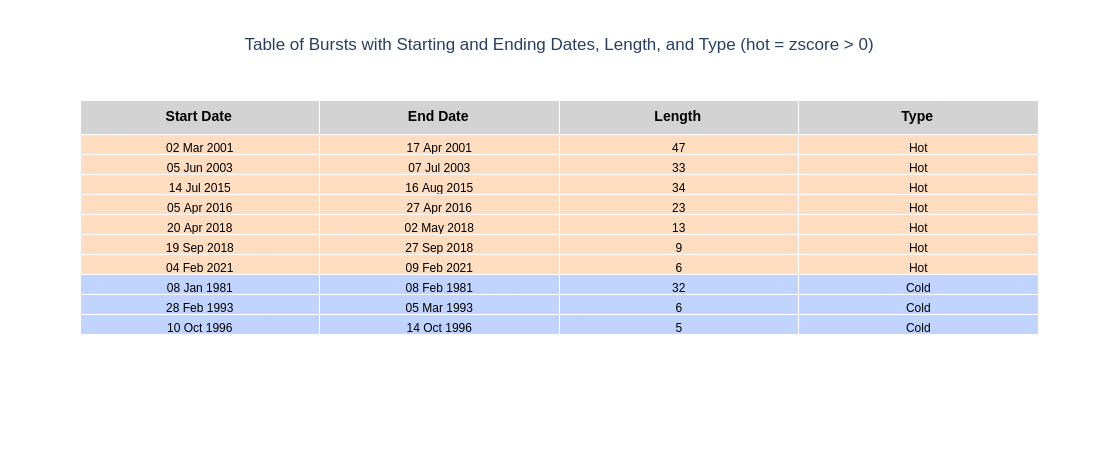

In [20]:
fig = utils.plot_table(bursts_df)
fig.update_layout(
    title="Table of Bursts with Starting and Ending Dates, Length, and Type (hot = zscore > 0)",
    title_x=0.5,
    width=750,
    height=450
)
fig.show()

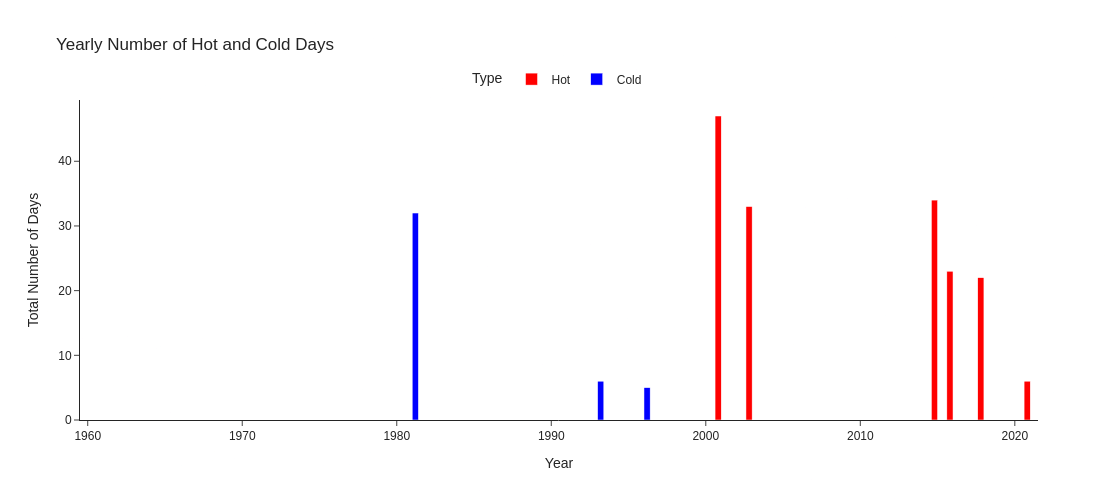

In [21]:
fig = utils.plot_bars(yearly_sum)
fig.update_layout(
    barmode='group',  # Group bars next to each other
    title="Yearly Number of Hot and Cold Days",
    xaxis_title="Year",
    yaxis_title="Total Number of Days",
    template="simple_white", 
    legend=dict(title="Type", orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5),
    width=800,
    height=500
)
fig.show()

Maximum: 3.5382557011944162, Minimum: -2.774360848504524


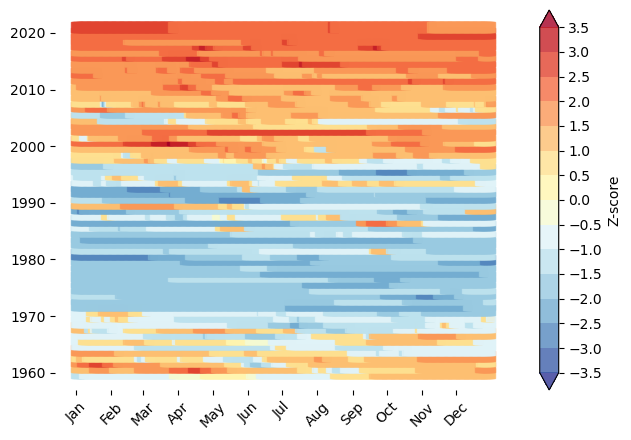

In [22]:
z_per_day = utils.compute_daily_zscore(ts, n_year, len_year)  
min_year = 1960
max_year = 2021
all_max, all_min = max(z_per_day), min(z_per_day)
print(f"Maximum: {all_max}, Minimum: {all_min}")
first_year, last_year = ts_date[0].year, ts_date[-1].year
# Discrete colorbar
abs_max = 3.5  # max(abs(all_max), abs(all_min))
levels = np.arange(-abs_max, abs_max+0.5, 0.5)
norm = BoundaryNorm(boundaries=levels, ncolors=256, extend='both')
x = np.arange(len_year)
plt.figure(figsize=(6.5,4.5))
for year in range(n_year):
    if max_year < year + first_year or year + first_year < min_year:
        continue
    plt.scatter(x, np.ones(len_year) * year + first_year, c=z_per_day[year * len_year:(year + 1) * len_year], 
                cmap=cm.RdYlBu_r, norm=norm, marker='s', s=50, alpha=0.8)

cbar = plt.colorbar(ticks=levels)
cbar.set_label('Z-score'), plt.xticks(first_day_of_months, str_dates, rotation=45), plt.tight_layout()
for pos in ['right', 'top', 'bottom', 'left']: plt.gca().spines[pos].set_visible(False)
plt.show()

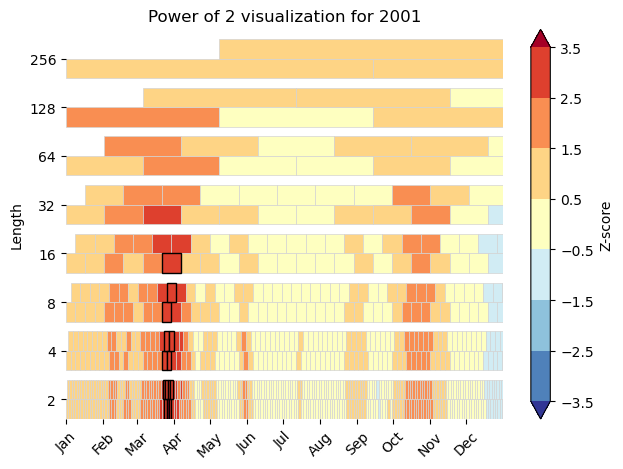

In [23]:
year = 2001 

swt_val = utils.SWT_per_year(ts, n_year, len_year)
swt = utils.z_score_SWT(swt_val, n_year, len_year, threshold, ts)

start_j = len_year * (year - first_year)
dates = ts_date[start_j:start_j+len_year]
abs_max = 3.5
fig, ax = plt.subplots()
ax.set_ylim(1, 9), ax.set_xlim(0, len_year)
utils.plot_bricks_with_z_score(swt, year - first_year, abs_max, ax)
plt.yticks(np.arange(1.4,9,1), [f"{2**i}" for i in range(1,9)]), plt.title(f"Power of 2 visualization for {year}")
plt.xticks(first_day_of_months, str_dates, rotation=45)
plt.ylabel("Length"), plt.tight_layout()
for pos in ['right', 'top', 'bottom', 'left']: plt.gca().spines[pos].set_visible(False)

In [25]:
%%capture output
if export:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        os.system('jupyter nbconvert --no-input --output ' + filename_html + ' --to html ' + "paper_single.ipynb")